# Test av loddtrekning for stipendiatstillinger

#### Hans Ekkehard Plesser, 2026-02-12

Denne notebooken gjennomfører en test av koden for stipendiatlotteriet.

------------------------

## Test av koden

For å teste at metoden gir resultater som er forventet innenfor statistisk variasjon, lager jeg et sett med 30 fiktive navn og kjører lotteriet for alle dager med valutakursdata i flere år tilbake. Så bruker jeg $\chi^2$-testen for å teste at antall ganger hver mulig veileder ble trukket ut er forenlig med en likefordeling.

### Bygg en liste med fiktive navn

For enkelthelts skyld er navnene bare tallene fra 0 til 29.

In [1]:
tickets = list(range(30))
dekanens_tall = "12345"

### Gjennomfør lotteriet mange ganger

- Koden gjennomfører lotteriet for alle dager mellom 1.1.2021 til 31.01.2026.
- Dager der det ikke finnes valutakurser utelates.
- "Navn" på vinnerne samles i en liste som analyseres i neste steg.
- Koden tar en tid å kjøre, tegn som skrives ut markerer fremgangen i koden (`-` markerer dager ute valutadata)

In [2]:
from datetime import date, timedelta
from lotteri import lotteri

start_date = date(2021, 1, 1)
end_date = date(2026, 1, 31)

current_date = start_date
results = []
ctr = 1
while current_date <= end_date:
    try:
        # Vi ser bort fra startverdien, tar bare inn navnet til vinneren
        results.append(lotteri(tickets, current_date.strftime("%Y-%m-%d"), dekanens_tall)[1])
        print("*", end="")
    except RuntimeError:
        print("-", end="")
    if ctr % 80 == 0:
        print()

    current_date += timedelta(days=1)
    ctr += 1

---*****--*****--*****--*****--*****--*****--*****--*****--*****--*****--*****--
*****--***-----****--*****--*****--*****--*****--***-*---****---****--*****--***
**--*****--*****--*****--*****--*****--*****--*****--*****--*****--*****--*****-
-*****--*****--*****--*****--*****--*****--*****--*****--*****--*****--*****--**
***--*****--*****--*****--*****--****---*****--*****--*****--*****--*****--*****
--*****--*****--*****--*****--*****--*****--*****--*****--*****--***-----****--*
****--*****--*****--*-***--***-*--*****---****--*****--*****--*****--*****--****
*--*****--*****--*****--*****--*****--*****--*****--*****--*****--*****--*****--
*****--*****--*****--*****--*****--*****--*****--*****--*****--*****--*****--***
**---****--*****--*****--*****--*****--*****--*****--*****--*****--*****--*****-
-*****--*****--*****--***-----****--*****--*****---****--*****--**--*--*****---*
***--*****--*****--*****--*****--*****--*****--*****--*****--*****--*****--*****
--*****--*****--*****--*****

### Se litt på resultatene

In [3]:
print("Antall vinnere trukket:", len(results))

Antall vinnere trukket: 1280


In [4]:
results[:20]

[27, 18, 10, 17, 26, 23, 8, 17, 26, 9, 21, 23, 20, 13, 19, 6, 18, 13, 15, 22]

### Tell opp hvor ofte hver deltaker vant


In [5]:
ganger_vunnet = [0] * len(tickets)
for vinner in results:
    ganger_vunnet[vinner] += 1

### Vis fordelingen av antall ganger vunnet

Eksperimentet ovenfor har gjennomført lotteriet med 30 deltakere og 1280 trekniger. Vi kan nå se på hvor mange deltakere vil da total ha vunnet, f eks, 5, 10 eller 20 ganger. Resultatene skal være binomialfordelt for 1280 trekninger med vinnersannsylighet 1/30.

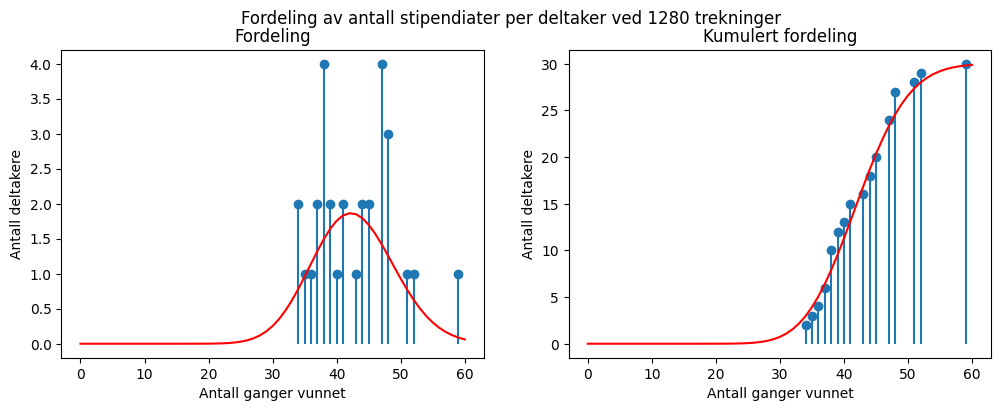

In [10]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom

vinn_fordeling = dict(sorted(Counter(ganger_vunnet).items()))
x = np.arange(60.5)
nd = len(tickets)
b = binom(n=len(results), p=1/nd)

fig = plt.figure(figsize=(12, 4))
axl = fig.add_subplot(1, 2, 1)
axl.stem(vinn_fordeling.keys(), vinn_fordeling.values(), basefmt='None');
axl.plot(x, nd * b.pmf(x), 'r');
axl.set_xlabel("Antall ganger vunnet");
axl.set_ylabel("Antall deltakere");
axl.set_title("Fordeling");

axr = fig.add_subplot(1, 2, 2)
axr.stem(vinn_fordeling.keys(), np.cumsum(list(vinn_fordeling.values())), basefmt='None');
axr.plot(x, nd * b.cdf(x), 'r');
axr.set_xlabel("Antall ganger vunnet");
axr.set_ylabel("Antall deltakere");
axr.set_title("Kumulert fordeling");

fig.suptitle(f"Fordeling av antall stipendiater per deltaker ved {sum(ganger_vunnet)} trekninger");

- Grafen viser resultatene fra trekningen i blått og den forventede binomialfordelingen i rødt.
- Grafen til venstre viser en betydelig spredning i antall stipendiater tildelt: Skulle vi fordele 1280 stipendiater med denne metoden mellom 30 veiledere, ville noen få tildelt så få som 34, mens andre vil få så mange som 59, med forventet snitt cirkapå omtrent 43.
- Den kumulerte fordelingen til høyre viser at resultatene fra lotteriet er i godt samsvar med teoretisk forventning.

### Gjennomfør $\chi^2$-testen

In [7]:
from scipy.stats import chisquare
chi2 = chisquare(ganger_vunnet)
print(f"Observasjoner totalt       : {sum(ganger_vunnet):5d}")
print(f"Minste antall observasjoner: {min(ganger_vunnet):5d}")
print(f"p-verdi                    : {chi2.pvalue:10.4f}")

Observasjoner totalt       :  1280
Minste antall observasjoner:    34
p-verdi                    :     0.7071


- Med 34 observasjoner for den minst hyppige kategorien er forutsetningene for $\chi^2$-testen oppfylt. 
- $p$-verdien på 0.71 tilsier at nullhypotesen om likefordeling av resultatene ikke skal forkastes.